In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import gc

DATADIR = ""
CATEGORIES = ["Anime","NotAnime2"]

In [2]:
import random

IMG_SIZE = 256
X = []
Y = []

#Data pre-processing function that resizes and loads data, shuffles it, splits it into features and labels
#and returns the features as a numpy array
def create_training_data(cutoff_size):
    features = []
    labels = []
    training_data = []
    for category in CATEGORIES:
        #Joins the DATADIR path with the category (Anime or NotAnime)
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            #read each image in the directory and grayscale it
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
                new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_CUBIC)
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
    #Trim it to first 2000 images and labels
    training_data = training_data[:cutoff_size]
    #Shuffle the data
    random.shuffle(training_data)
    #Split up labels and features
    for feature, label in training_data:
        features.append(feature)
        labels.append(label)
    return np.array(features), labels

#Create the numpy array of training images and labels
#X, Y = create_training_data(2000)

#Load the 
X = np.load('Numpy/X_general.npy')
Y = np.load('Numpy/Y_general.npy')
print("Length of feature list is: {}. Length of label list is: {}".format(len(X),len(Y)))

0
0
1
1
0


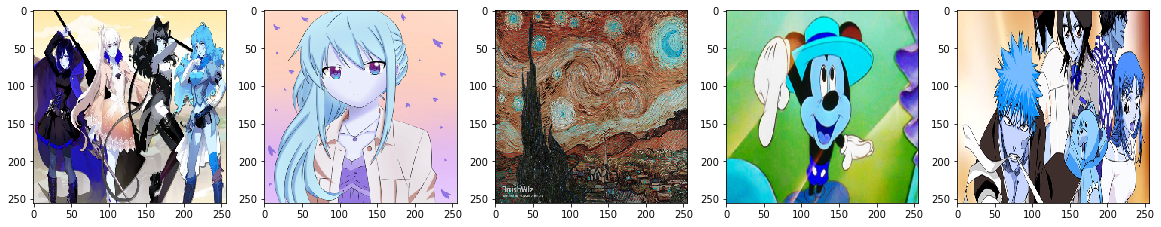

In [4]:
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5/columns+1,columns,i+1)
    plt.imshow(X[i])
    print(Y[i])
    
#0 is Anime and 1 is not anime

Text(0.5, 1.0, 'Labels for Anime and NotAnime')

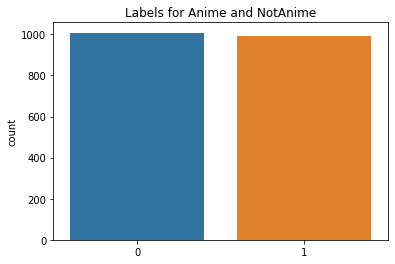

In [5]:
import seaborn as sns

#Save the numpy arrays
#np.save('X_general.npy',X)
#np.save('Y_general.npy',Y)

sns.countplot(Y)
plt.title('Labels for Anime and NotAnime')

In [6]:
#Split the data into the train and test set
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=2)

print("Train Image shape is: {}".format(X_train.shape))
print("Validation Image shape is: {}".format(X_val.shape))
print("Train Label shape is: {}".format(len(y_train)))
print("Validation Label shape is: {}".format(len(y_val)))

Train Image shape is: (1600, 256, 256, 3)
Validation Image shape is: (400, 256, 256, 3)
Train Label shape is: 1600
Validation Label shape is: 400


In [7]:
#Garbage collect the full set of features and labels
del X
del Y
gc.collect()

#Set batch_size
ntrain = len(X_train)
nval = len(X_val)
batch_size = 20

In [8]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import layers,models,optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

#Enable GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True 

sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras


Using TensorFlow backend.


In [9]:
#Test to see if GPU is enabled
from keras import backend as k
k.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [16]:
from keras.applications import InceptionResNetV2

conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(256,256,3))
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 127, 127, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 127, 127, 32) 0           batch_normalization_204[0][0]    
__________________________________________________________________________________________________
conv2d_205

In [17]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 6, 6, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 55296)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               14156032  
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 68,493,025
Trainable params: 68,432,481
Non-trainable params: 60,544
_________________________________________________________________


In [18]:
type(conv_base)

keras.engine.training.Model

In [19]:
print('Num of trainable weights before freezing conv base: ', len(model.trainable_weights))
conv_base.trainable = False
print('Num of trainable weights after freezing conv base', len(model.trainable_weights))

Num of trainable weights before freezing conv base:  492
Num of trainable weights after freezing conv base 4


In [20]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

In [21]:
#image data generator that randomly applies some transformatiosn to improve dataset as well as normalizes pixel values
#to have std deviation of 1 (rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
train_generator = train_datagen.flow(X_train,y_train,batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [23]:
#Set up history of model's training progress
history = model.fit_generator(train_generator,
                             steps_per_epoch=ntrain//batch_size,
                             epochs=20,
                             validation_data=val_generator,
                             validation_steps=nval // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
80/80 [==============================] - 38s 478ms/step - loss: 0.5456 - acc: 0.7350 - val_loss: 0.4626 - val_acc: 0.8375
Epoch 2/20
80/80 [==============================] - 16s 206ms/step - loss: 0.4359 - acc: 0.8025 - val_loss: 0.6673 - val_acc: 0.7700
Epoch 3/20
80/80 [==============================] - 17s 211ms/step - loss: 0.3477 - acc: 0.8469 - val_loss: 0.4680 - val_acc: 0.8575
Epoch 4/20
80/80 [==============================] - 18s 223ms/step - loss: 0.3320 - acc: 0.8556 - val_loss: 0.5168 - val_acc: 0.8400
Epoch 5/20
80/80 [==============================] - 18s 224ms/step - loss: 0.3476 - acc: 0.8619 - val_loss: 0.5305 - val_acc: 0.8575
Epoch 6/20
80/80 [==============================] - 18s 227ms/step - loss: 0.3204 - acc: 0.8600 - val_loss: 0.4370 - val_acc: 0.8575
Epoch 7/20
80/80 [==============================] - 19s 235ms/step - loss: 0.2884 - acc: 0.8819 - val_loss: 0.7307 - val_acc: 0.8050
Epoch 8/20
80/80 [===

In [24]:
model.save_weights('Weights/incpetion_model_weights.h5')
model.save('Models/inception_model_keras.h5')

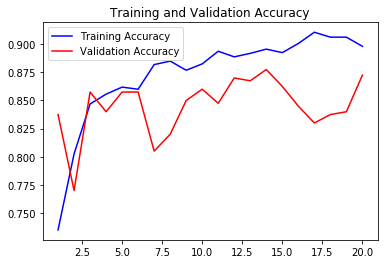

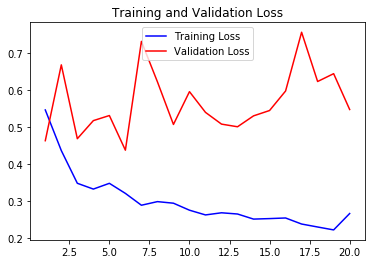

In [25]:
#Plot history progress
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

#Train and validation accuracy
plt.plot(epochs,acc, 'b', label= 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs,loss, 'b', label= 'Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [4]:
def create_test_data(cutoff_size):
    features = []
    test_data = []
    #Joins the DATADIR path with the category (Anime or NotAnime)
    for img in os.listdir(DATADIR):
        #read each image in the directory and read it in color
        try:
            img_array = cv2.imread(os.path.join(DATADIR,img),cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_CUBIC)
            test_data.append(new_array)
        except Exception as e:
            pass
    #Trim the test data to specified number
    test_data = test_data[:cutoff_size]
    #Shuffle the data
    random.shuffle(test_data)
    #Split up labels and features
    for feature in test_data:
        features.append(feature)
    return np.array(features)



In [5]:
DATADIR=''
X_test = create_test_data(10)
test_datagen = ImageDataGenerator(rescale=1./255)

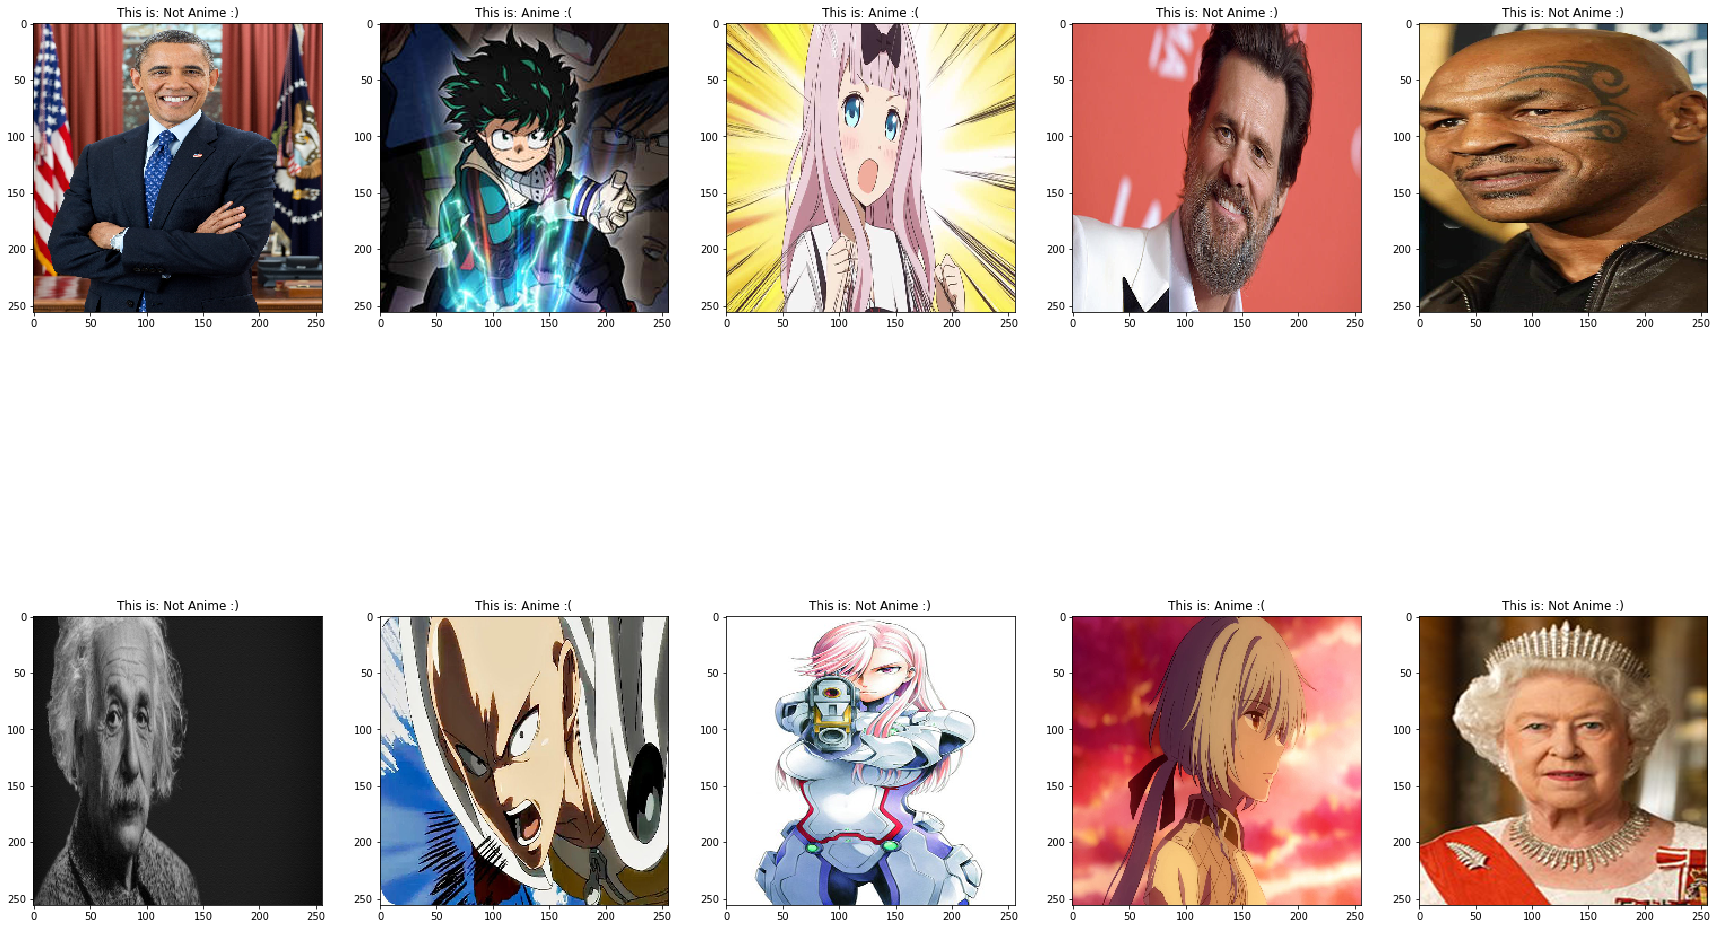

In [29]:
#0 if anime and 1 if not anime

i = 0
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(X_test, batch_size=1):
    pred = model.predict(batch)
    if pred > 0.5:
        text_labels.append('Not Anime :)')
    else:
        text_labels.append('Anime :(')
    plt.subplot(5/ columns +1, columns, i +1)
    plt.title('This is: ' + text_labels[i])
    imgplot = plt.imshow(cv2.cvtColor(batch[0], cv2.COLOR_BGR2RGB))
    i += 1
    if i % 10 == 0:
        break
plt.show()